In [132]:
pip install langgraph langchain langchain-core langchain-community duckduckgo-search ipython jupyter typing-extensions

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [133]:
pip install langchain_groq dotenv

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [134]:
from langgraph.graph import MessagesState,StateGraph,END,START
from langchain_core.messages import HumanMessage,SystemMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import tools_condition
from  IPython.display import Image, display
from typing import Annotated,TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode

In [135]:
from langchain_groq import ChatGroq
import dotenv
dotenv.load_dotenv()
llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0.0)

In [136]:

from langchain.agents import tool
@tool
def multiply(a:int, b:int) ->int:
    """this tool Mutiplies the numbers
    Args:
    a:int
    b:int
    """
    return a*b

In [137]:
@tool
def add(a:int, b:int) ->int:
    """this tool adds the numbers
    Args:
    a:int
    b:int
    """
    return a+b

In [138]:
from langchain_community.tools import DuckDuckGoSearchRun
search=DuckDuckGoSearchRun()

In [139]:
search.invoke({"query":"what is the capital of India"})

'27 May 2025 — Capital, New Delhi · 28°36′50″N 77°12′30″E / 28.61389°N 77.20833°E ... Socio-economic challenges. Main articles: Poverty in India, Income inequality in India, ... As the capital of India , Delhi is the focus of political reportage, including regular television broadcasts of Parliament sessions. Many national media agencies, including the state-owned Press Trust of India , Media Trust of India and Doordarshan, are based in the city. 12 Nov 2024 — If you are asked what the capital of India is, your answer will be New Delhi , which was settled by the British. Thus, in 1911, New Delhi became the capital of India , south of the Old City of Delhi. And then over the years, Delhi expanded, and satellite cities sprang up- ... 9 Jan 2025 — New Delhi was finally inaugurated as the capital on 13 February 1931, by the then Viceroy of India, Lord Irwin. The new capital was built along wide boulevards ...'

In [140]:
import yfinance as yf
@tool
def get_stock_price(ticker: str) -> float:
    """Get the current stock price of a company."""
    stock = yf.Ticker(ticker)
    return stock.info["currentPrice"]

In [141]:
tools = [multiply,add,search,get_stock_price]
llm_with_tools=llm.bind_tools(tools)

In [142]:
system_message = SystemMessage(
    content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs."
)

In [143]:
def reasoner(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([system_message]+state["messages"])]}


In [144]:
app=StateGraph(MessagesState)
app.add_node("reasoner",reasoner)
app.add_node("tools",ToolNode(tools))
app.add_edge(START,"reasoner")
app.add_conditional_edges("reasoner",tools_condition)
app.add_edge("tools","reasoner")
react_graph=app.compile() 

In [145]:
messages=[HumanMessage(content="what is donald trumps age 2 times?")]

In [146]:
messages=react_graph.invoke({"messages":messages})

In [147]:
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is donald trumps age 2 times?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (1a5va1tfm)
 Call ID: 1a5va1tfm
  Args:
    query: donald trump age
  add (n32nzbq09)
 Call ID: n32nzbq09
  Args:
    a: 76
    b: 2
================================= Tool Message =================================
Name: duckduckgo_search

7 hours ago - Donald John Trump ( born June 14, 1946 ) is an American politician, media personality, and businessman who is the 47th president of the United States. A member of the Republican Party, he served as the 45th president from 2017 to 2021. Born into a wealthy family in New York City, Trump graduated ... 11 hours ago - At 79 years old , Donald Trump, the 47th and previously 45th president of the United States, is the oldest person in American history to be inaugurated as president for the second time. He became the o

In [148]:
get_stock_price("AAPL")

239.69

In [149]:
tools = [multiply,add,search,get_stock_price]
llm_with_tools=llm.bind_tools(tools)

In [150]:
class GraphState(TypedDict):
    """State of the Graph"""
    query: str
    finance: str
    final_answer: str
    # intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]


def reasoner2(state:GraphState):
    query = state["query"]
    messages = state["messages"]
    # System message
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages":result}

In [151]:
workflow=StateGraph(GraphState)

workflow.add_node("reasoner2",reasoner2)
workflow.add_node("tools",ToolNode(tools2))
workflow.add_edge(START,"reasoner2")
workflow.add_conditional_edges("reasoner2",tools_condition)
workflow.add_edge("tools","reasoner2")

react_graph2=workflow.compile() 


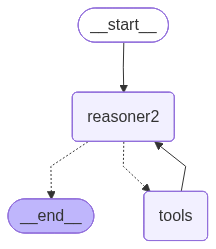

In [152]:

# Display the graph
display(Image(react_graph2.get_graph(xray=True).draw_mermaid_png()))

In [153]:
res=react_graph2.invoke({"query":"whats the stock price of apple?","messages":[]})

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [ ]:
for m in messages["messages"]:
    m.pretty_print()